In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

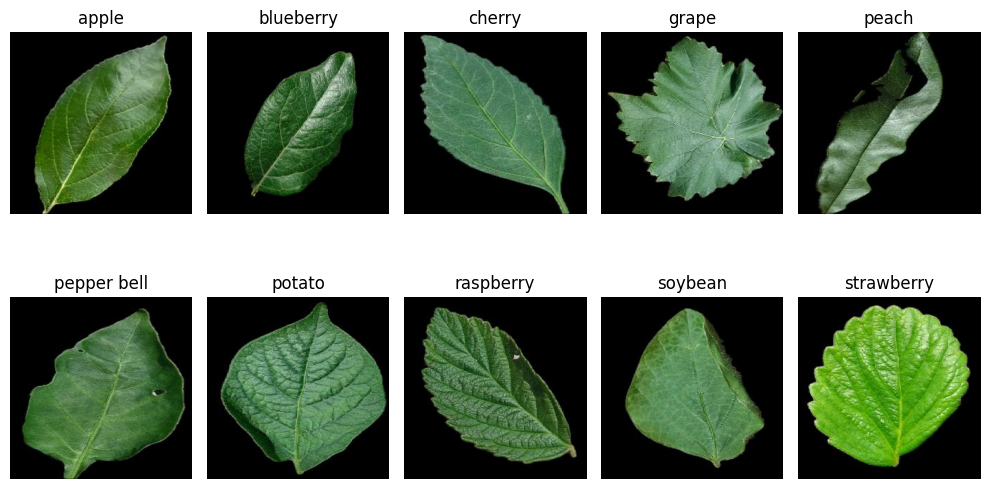

In [ ]:
dataset = "/content/drive/MyDrive/dataset"
leaves = ['apple', 'blueberry', 'cherry', 'grape', 'peach', 'pepper bell', 'potato', 'raspberry', 'soybean', 'strawberry']

image_data = {}

for folder in leaves:
    folder_path = os.path.join(dataset, folder)
    image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith('.jpg')]
    images = []
    for image_file in image_files:
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    image_data[folder] = images

fig, axs = plt.subplots(2, 5, figsize=(9, 6))
axs = axs.ravel()

for i, folder in enumerate(leaves):
    image = image_data[folder][0]
    axs[i].imshow(image)
    axs[i].set_title(folder)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
preprocessed = r"C:\Users\Mon\team 16 project\preprocessed_dataset"

def skeletonize(image):
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False
    size = np.size(image)
    skel = np.zeros(image.shape, np.uint8)

    while not done:
        eroded = cv2.erode(image, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(image, temp)
        skel = cv2.bitwise_or(skel, temp)
        image = eroded.copy()

        zeros = size - cv2.countNonZero(image)
        if zeros == size:
            done = True

    return skel

for leaf in os.listdir(dataset):
    leaf_dir = os.path.join(dataset, leaf)
    save_folder = os.path.join(preprocessed, leaf)
    os.makedirs(save_folder, exist_ok=True)

    for file in os.listdir(leaf_dir):
        if file.lower().endswith('.jpg'):
            image = cv2.imread(os.path.join(leaf_dir, file))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            edges = cv2.Sobel(blurred, cv2.CV_64F, 1, 1, ksize=5)
            _, binary = cv2.threshold(np.abs(edges), 50, 255, cv2.THRESH_BINARY)
            skeleton = skeletonize(binary.astype(np.uint8))

            save_path = os.path.join(save_folder, file)
            cv2.imwrite(save_path, skeleton)


In [ ]:
for index, label in enumerate(leaves):
    print(f"Label {index}: {label}")

Label 0: apple
Label 1: blueberry
Label 2: cherry
Label 3: grape
Label 4: peach
Label 5: pepper bell
Label 6: potato
Label 7: raspberry
Label 8: soybean
Label 9: strawberry


In [ ]:
data = tf.keras.utils.image_dataset_from_directory(
   r"C:\Users\Mon\team 16 project\preprocessed_dataset",
   color_mode='grayscale',
   batch_size=32,
   image_size=(256, 256),
)

Found 1000 files belonging to 10 classes.


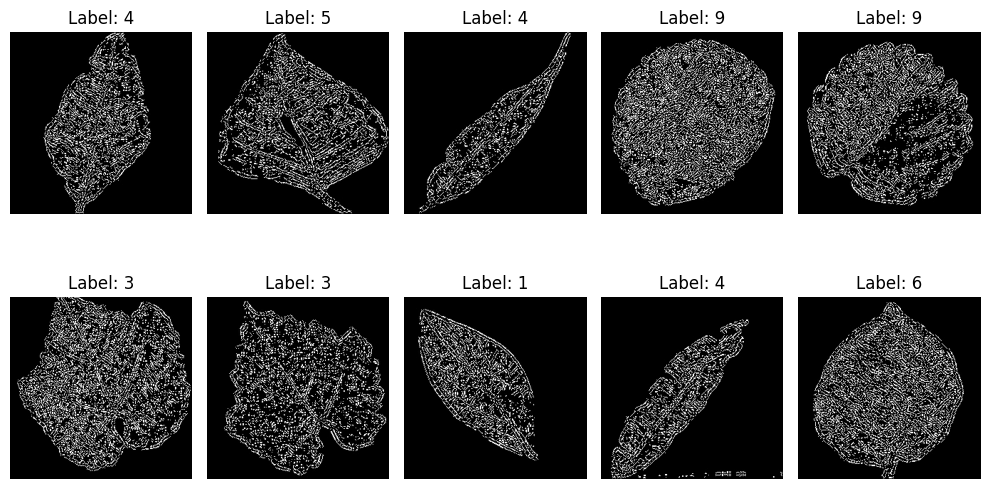

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 6))
for images, labels in data.take(1):
    for i in range(10):
        row = i // 5
        col = i % 5
        axes[row, col].imshow(images[i], cmap='gray')
        axes[row, col].set_title(f"Label: {labels[i].numpy()}")
        axes[row, col].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [ ]:
data = data.map(lambda x,y:(x/255,y))
#data.as_numpy_iterator().next()

In [ ]:
scaled = data.as_numpy_iterator()

In [ ]:
batch = scaled.next()
batch[0].shape

(32, 256, 256, 1)

In [ ]:
train_size = int(len(data)*.7)
test_size = int(len(data)*.1)+1
val_size = int(len(data)*.2)

In [ ]:
train_size, test_size, val_size

(22, 4, 6)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,1)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (5,5), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist = model.fit(train, epochs=40, validation_data=val)

Epoch 1/40
22/22 [==============================] - 9s 68ms/step - loss: 2.3982 - accuracy: 0.1307 - val_loss: 2.2865 - val_accuracy: 0.2865
Epoch 2/40
22/22 [==============================] - 2s 67ms/step - loss: 2.2185 - accuracy: 0.1889 - val_loss: 2.0619 - val_accuracy: 0.3854
Epoch 3/40
22/22 [==============================] - 2s 89ms/step - loss: 1.8990 - accuracy: 0.3423 - val_loss: 1.4658 - val_accuracy: 0.5365
Epoch 4/40
22/22 [==============================] - 2s 70ms/step - loss: 1.5970 - accuracy: 0.4276 - val_loss: 1.3427 - val_accuracy: 0.5677
Epoch 5/40
22/22 [==============================] - 1s 61ms/step - loss: 1.3759 - accuracy: 0.5156 - val_loss: 1.1054 - val_accuracy: 0.6458
Epoch 6/40
22/22 [==============================] - 1s 60ms/step - loss: 1.0911 - accuracy: 0.6151 - val_loss: 0.8194 - val_accuracy: 0.7448
Epoch 7/40
22/22 [==============================] - 1s 60ms/step - loss: 0.9932 - accuracy: 0.6591 - val_loss: 0.8213 - val_accuracy: 0.7396
Epoch 8/40
22

In [ ]:
from sklearn.metrics import accuracy_score

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

test_loss, test_acc = model.evaluate(test)

print("Training Accuracy:", train_acc[-1])
print("Validation Accuracy:", val_acc[-1])
print("Test Accuracy:", test_acc)

4/4 [==============================] - 1s 103ms/step - loss: 0.2475 - accuracy: 0.9327
Training Accuracy: 0.9744318127632141
Validation Accuracy: 0.921875
Test Accuracy: 0.932692289352417


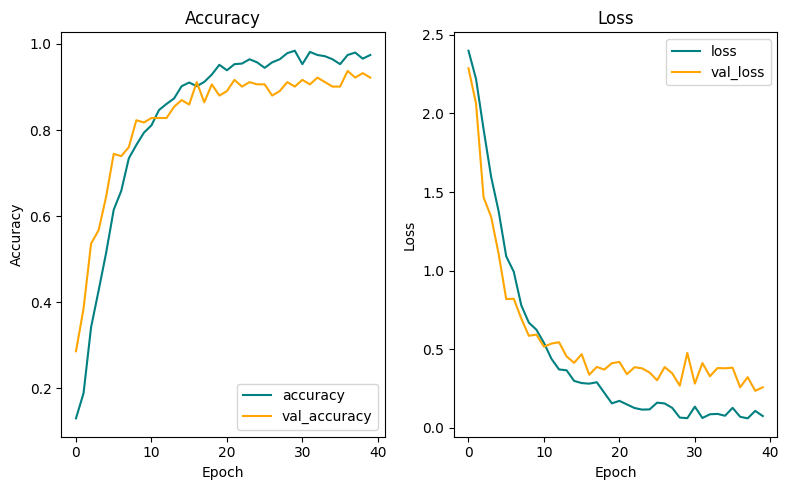

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

axes[0].plot(hist.history['accuracy'], color='teal', label='accuracy')
axes[0].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc="lower right")

axes[1].plot(hist.history['loss'], color='teal', label='loss')
axes[1].plot(hist.history['val_loss'], color='orange', label='val_loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [ ]:
test_batch = test.take(1)
images, labels = next(iter(test_batch))
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

1/1 [==============================] - 0s 112ms/step


In [ ]:
for i in range(len(labels)):
    print(f"Ground truth: {labels[i]}, Predicted: {predicted_labels[i]}")

Ground truth: 2, Predicted: 2
Ground truth: 4, Predicted: 4
Ground truth: 0, Predicted: 1
Ground truth: 8, Predicted: 8
Ground truth: 0, Predicted: 0
Ground truth: 9, Predicted: 9
Ground truth: 1, Predicted: 1
Ground truth: 8, Predicted: 6
Ground truth: 0, Predicted: 4
Ground truth: 6, Predicted: 6
Ground truth: 6, Predicted: 6
Ground truth: 4, Predicted: 4
Ground truth: 6, Predicted: 6
Ground truth: 9, Predicted: 9
Ground truth: 3, Predicted: 3
Ground truth: 8, Predicted: 8
Ground truth: 6, Predicted: 6
Ground truth: 5, Predicted: 5
Ground truth: 3, Predicted: 3
Ground truth: 2, Predicted: 2
Ground truth: 1, Predicted: 1
Ground truth: 2, Predicted: 2
Ground truth: 3, Predicted: 3
Ground truth: 3, Predicted: 3
Ground truth: 0, Predicted: 0
Ground truth: 5, Predicted: 5
Ground truth: 7, Predicted: 7
Ground truth: 8, Predicted: 8
Ground truth: 7, Predicted: 7
Ground truth: 0, Predicted: 0
Ground truth: 6, Predicted: 6
Ground truth: 3, Predicted: 3


In [ ]:
correct_predictions = np.sum(predicted_labels == labels)
total_images = len(labels)
print(f"Correctly predicted images: {correct_predictions}/{total_images}")

Correctly predicted images: 29/32
